**Important Disclaimer:** Mockup. So far, the example here does not support
fit or predict, let alone hyperparameter tuning etc.

The pipeline shown here assumes the example input tables from
<a href="https://arxiv.org/pdf/1706.00327.pdf#page=3">Fig. 2</a>
of the following paper:
Hoang Thanh Lam, Johann-Michael Thiebaut, Mathieu Sinn, Bei Chen, Tiep Mai, and Oznur Alkan.
"One button machine for automating feature engineering in relational databases". 2017. 
https://arxiv.org/abs/1706.00327

In [1]:
from lale.expressions import it, replace, sum, max, count, month, day_of_month, item
import numpy as np

In [2]:
from lale.lib.lale import Scan, Join, Map, GroupBy, Aggregate, ConcatFeatures
from sklearn.feature_selection import SelectKBest as SelectFeatures
from sklearn.pipeline import Pipeline
from lale.lib.autoai_libs import NumpyColumnSelector, CatEncoder, OptStandardScaler, FS1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

In [3]:
# one-to-one path doesn't need GroupBy >> Aggregate
info_features = (
       (Scan(table=it.main) & Scan(table=it.info))
    >> Join(pred=[it.main.TrainId == it.info.Train_Id, #note the underscore
                  it.main['Arrival time'] >= it.info.TimeStamp])
    >> Map(columns=[replace(it['Train class'], {'Regional': 0, 'Intercity': 1}),
                    it['Max Speed (km/h)'],
                    month(it['Arrival time'], fmt='YYYY-MM-DD HH:MM:SS'),
                    day_of_month(it['Arrival time'])]))
# one-to-many path (multiple delay rows per main-table row)
delay_features = (
       (Scan(table=it.main) & Scan(table=it.delay))
    >> Join(pred=[it.main.TrainId == it.delay.TrainId,
                  it.main['Arrival time'] >= it.delay.TimeStamp])
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(columns=[sum(it.Delay), max(it.Delay)]))
# multi-hop one-to-many path uses multi-way join
event_features = (
       (Scan(table=it.main) & Scan(table=it.delay) & Scan(table=it.event))
    >> Join(pred=[it.main.TrainId == it.delay.TrainId,
                  it.main['Arrival time'] >= it.delay.TimeStamp,
                  it.delay.StationId == it.event.StationId,
                  it.main.TimeStamp >= it.event.TimeStamp])
    >> GroupBy(key=it.MessageId) #primary key of main table
    >> Aggregate(columns=[count(it.Event),
                          item(it['Train class'], 'Roadwork')]))

In [4]:
all_features = Pipeline(steps=[('data_joins',
       (info_features & delay_features & event_features)
    >> ConcatFeatures >> SelectFeatures())])

In [5]:
cats_prep = NumpyColumnSelector(columns=[0]) >> CatEncoder(dtype=np.float64)
cont_prep = NumpyColumnSelector(columns=[1,2]) >> OptStandardScaler(use_scaler_flag=True)
all_prep = Pipeline(steps=[('preprocessing',
    (cats_prep & cont_prep) >> ConcatFeatures >> FS1(additional_col_count_to_keep=3))])

In [6]:
classifier = LR | KNN | XGBoost

In [7]:
pipeline = all_features >> all_prep >> classifier

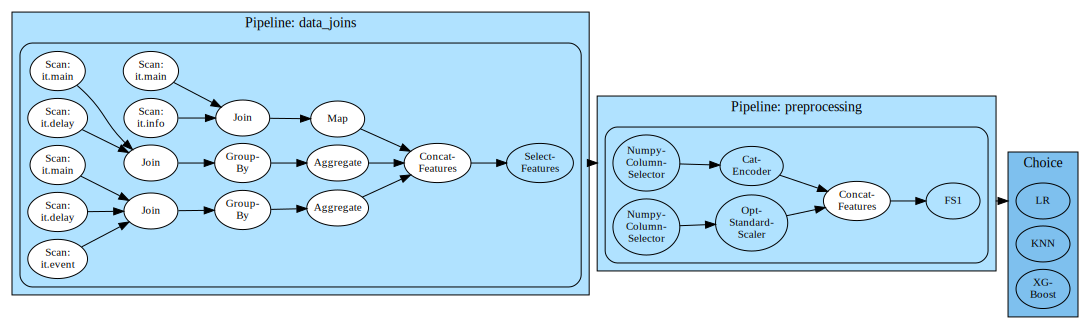

In [8]:
pipeline.visualize()

In [9]:
pipeline.pretty_print(ipython_display=True)

```python
from sklearn.pipeline import Pipeline
from lale.lib.lale import Scan
from lale.expressions import it
from lale.lib.lale import Join
from lale.lib.lale import Map
from lale.expressions import replace
from lale.expressions import month
from lale.expressions import day_of_month
from lale.lib.lale import GroupBy
from lale.lib.lale import Aggregate
from lale.expressions import sum
from lale.expressions import max
from lale.expressions import count
from lale.expressions import item
from lale.lib.lale import ConcatFeatures
from sklearn.feature_selection import SelectKBest as SelectFeatures
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import OptStandardScaler
from autoai_libs.cognito.transforms.transform_utils import FS1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier as XGBoost
import lale

lale.wrap_imported_operators()
scan = Scan(table=it.main)
scan_0 = Scan(table=it.info)
join = Join(
    pred=[
        (it.main.TrainId == it.info.Train_Id),
        (it.main["Arrival time"] >= it.info.TimeStamp),
    ]
)
scan_1 = Scan(table=it.main)
scan_2 = Scan(table=it.delay)
join_0 = Join(
    pred=[
        (it.main.TrainId == it.delay.TrainId),
        (it.main["Arrival time"] >= it.delay.TimeStamp),
    ]
)
group_by = GroupBy(key=it.MessageId)
aggregate = Aggregate(columns=[sum(it.Delay), max(it.Delay)])
scan_3 = Scan(table=it.main)
scan_4 = Scan(table=it.delay)
scan_5 = Scan(table=it.event)
join_1 = Join(
    pred=[
        (it.main.TrainId == it.delay.TrainId),
        (it.main["Arrival time"] >= it.delay.TimeStamp),
        (it.delay.StationId == it.event.StationId),
        (it.main.TimeStamp >= it.event.TimeStamp),
    ]
)
group_by_0 = GroupBy(key=it.MessageId)
aggregate_0 = Aggregate(
    columns=[count(it.Event), item(it["Train class"], "Roadwork")]
)
numpy_column_selector = NumpyColumnSelector(columns=[0])
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="ignore",
)
numpy_column_selector_0 = NumpyColumnSelector(columns=[1, 2])
fs1 = FS1(
    cols_ids_must_keep=[],
    additional_col_count_to_keep=3,
    ptype="classification",
)
pipeline_3 = Pipeline(
    steps=[
        (
            "preprocessing",
            (
                (numpy_column_selector >> cat_encoder)
                & (numpy_column_selector_0 >> OptStandardScaler())
            )
            >> ConcatFeatures
            >> fs1,
        )
    ]
)
pipeline = (
    Pipeline(
        steps=[
            (
                "data_joins",
                (
                    (
                        (scan & scan_0)
                        >> join
                        >> Map(
                            columns=[
                                replace({"Intercity": 1, "Regional": 0}),
                                it["Max Speed (km/h)"],
                                month(
                                    it["Arrival time"], "YYYY-MM-DD HH:MM:SS"
                                ),
                                day_of_month(it["Arrival time"]),
                            ]
                        )
                    )
                    & ((scan_1 & scan_2) >> join_0 >> group_by >> aggregate)
                    & (
                        (scan_3 & scan_4 & scan_5)
                        >> join_1
                        >> group_by_0
                        >> aggregate_0
                    )
                )
                >> ConcatFeatures
                >> SelectFeatures(),
            )
        ]
    )
    >> pipeline_3
    >> (LR | KNN | XGBoost)
)
```